In [1]:
%matplotlib inline

import pandas_datareader.data as web
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS

import numpy as np
import datetime
import requests_cache
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

expire_after = datetime.timedelta(days=5)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

In [2]:
sns.set_style('whitegrid')

In [3]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

##### Load monthly industrial production and daily NASDAQ stock market index:

In [4]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2023-12-31', session=session).squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2023-12-31', session=session).squeeze().dropna()

In [5]:
industrial_production

DATE
1988-01-01     55.6556
1988-02-01     56.8482
1988-03-01     57.5280
1988-04-01     57.7532
1988-05-01     57.8484
                ...   
2023-08-01    100.8403
2023-09-01    100.2211
2023-10-01    100.2605
2023-11-01     99.5743
2023-12-01     98.7004
Name: IPGMFN, Length: 432, dtype: float64

In [6]:
nasdaq

DATE
1990-01-02      459.33
1990-01-03      460.90
1990-01-04      459.39
1990-01-05      458.22
1990-01-08      458.71
                ...   
2023-12-22    14992.97
2023-12-26    15074.57
2023-12-27    15099.18
2023-12-28    15095.14
2023-12-29    15011.35
Name: NASDAQCOM, Length: 8566, dtype: float64

##### Additive Decomposition

In [7]:
components = tsa.seasonal_decompose(industrial_production, model='additive')

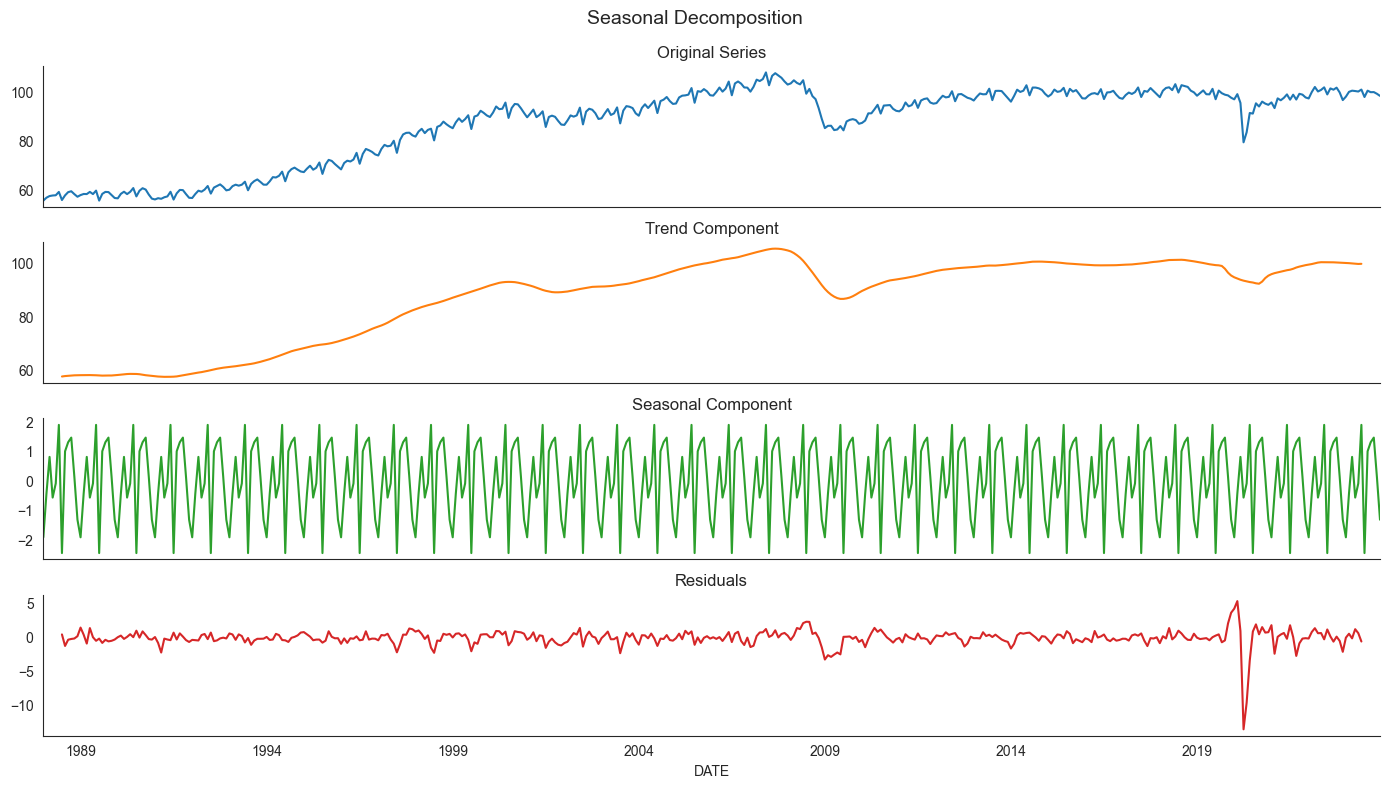

In [8]:
ts = (industrial_production.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

In [9]:
ts[:14]

,Original,Trend,Seasonality,Residual
DATE,,,,
1988-01-01,55.6556,NaN,-1.905054,NaN
1988-02-01,56.8482,NaN,-0.420784,NaN
1988-03-01,57.5280,NaN,0.825467,NaN
1988-04-01,57.7532,NaN,-0.555635,NaN
1988-05-01,57.8484,NaN,-0.075653,NaN
1988-06-01,59.2211,NaN,1.912620,NaN
1988-07-01,55.8901,57.822008,-2.441100,0.509191
1988-08-01,57.8103,57.980112,1.016002,-1.185815
1988-09-01,59.1313,58.077767,1.322921,-0.269388


In [10]:
(ts['Original'][:7] - ts['Trend'][7]).values.mean()

C:\Users\SHANKRITH_NATARAJAN\AppData\Local\Temp\1\ipykernel_15644\927471661.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (ts['Original'][:7] - ts['Trend'][7]).values.mean()


-0.7308839285714269

##### Log transformation and Differencing

In [11]:
(nasdaq == 0).any(), (industrial_production==0).any()

(False, False)

In [12]:
nasdaq_diff = nasdaq.diff().dropna()
industrial_production_diff = industrial_production.diff().dropna()

In [13]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

In [14]:
nasdaq_log_diff = nasdaq_log.diff().dropna()
industrial_production_log_diff = industrial_production_log.diff(periods=12).dropna()

C:\Users\SHANKRITH_NATARAJAN\AppData\Local\Temp\1\ipykernel_15644\3080438344.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  s=f'KPSS: {tsa.kpss(nasdaq.dropna())[1]:.4f}',
C:\Users\SHANKRITH_NATARAJAN\AppData\Local\Temp\1\ipykernel_15644\3080438344.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  s=f'KPSS: {tsa.kpss(nasdaq_log.dropna())[1]:.4f}',
C:\Users\SHANKRITH_NATARAJAN\AppData\Local\Temp\1\ipykernel_15644\3080438344.py:42: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  s=f'KPSS: {tsa.kpss(nasdaq_log_diff.dropna())[1]:.4f}',
C:\Users\SHANKRITH_NATARAJAN\AppData\Local\Temp\1\ipykernel_15644\3080438344.py:52: Int

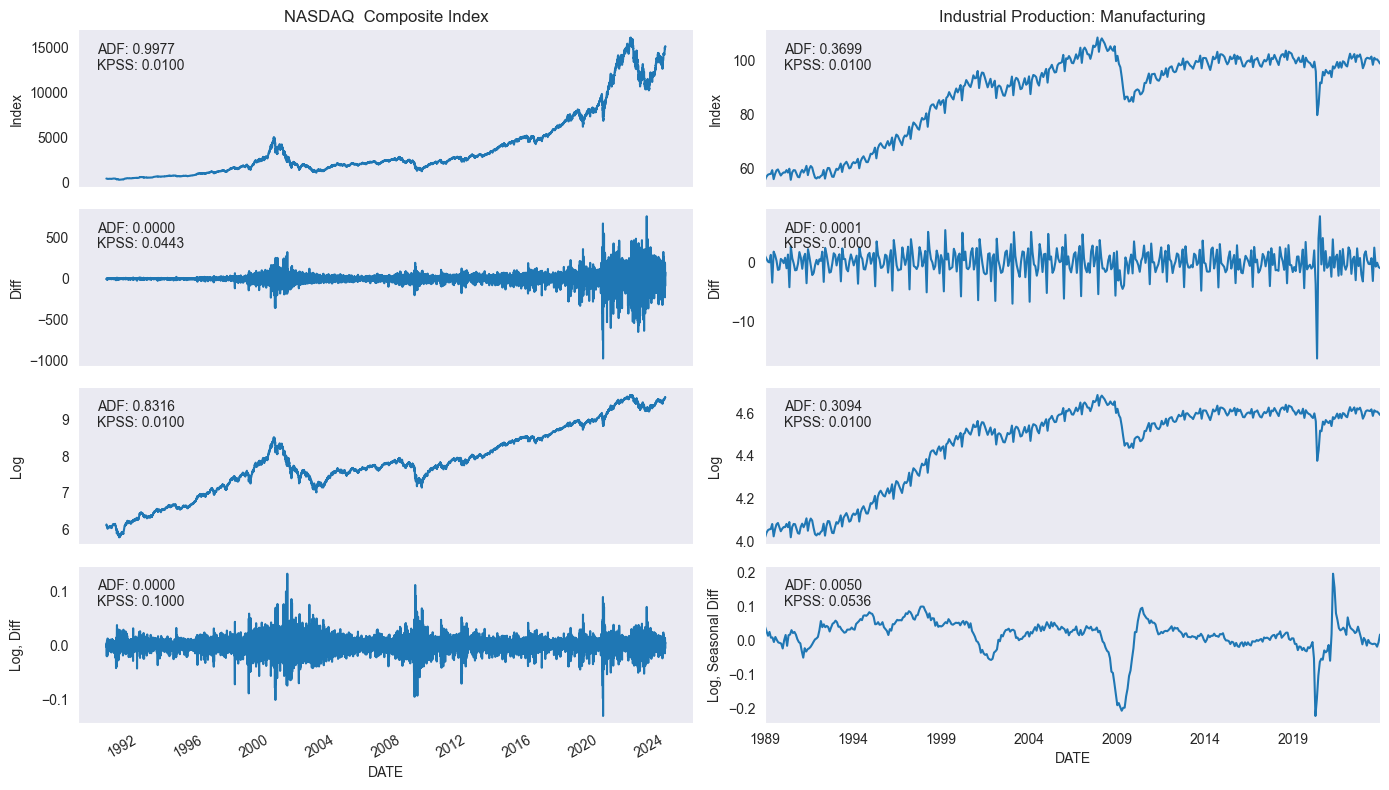

In [15]:
with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 8))

    nasdaq.plot(ax=axes[0][0],
                title='NASDAQ  Composite Index')
    axes[0][0].text(x=.03,
                    y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq.dropna())[1]:.4f}',
                    transform=axes[0][0].transAxes)
    axes[0][0].text(x=.03, y=.75,
                    s=f'KPSS: {tsa.kpss(nasdaq.dropna())[1]:.4f}',
                    transform=axes[0][0].transAxes)
    axes[0][0].set_ylabel('Index')

    nasdaq_diff.plot(ax=axes[1][0],
                     sharex=True)
    axes[1][0].text(x=.03,
                    y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq_diff.dropna())[1]:.4f}',
                    transform=axes[1][0].transAxes)
    axes[1][0].text(x=.03, y=.75,
                    s=f'KPSS: {tsa.kpss(nasdaq_diff.dropna())[1]:.4f}',
                    transform=axes[1][0].transAxes)
    axes[1][0].set_ylabel('Diff')

    nasdaq_log.plot(ax=axes[2][0],
                    sharex=True)
    axes[2][0].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq_log.dropna())[1]:.4f}',
                    transform=axes[2][0].transAxes)
    axes[2][0].text(x=.03, y=.75,
                    s=f'KPSS: {tsa.kpss(nasdaq_log.dropna())[1]:.4f}',
                    transform=axes[2][0].transAxes)
    axes[2][0].set_ylabel('Log')

    nasdaq_log_diff.plot(ax=axes[3][0],
                         sharex=True)
    axes[3][0].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq_log_diff.dropna())[1]:.4f}',
                    transform=axes[3][0].transAxes)
    axes[3][0].text(x=.03, y=.75,
                    s=f'KPSS: {tsa.kpss(nasdaq_log_diff.dropna())[1]:.4f}',
                    transform=axes[3][0].transAxes)
    axes[3][0].set_ylabel('Log, Diff')

    industrial_production.plot(ax=axes[0][1],
                               title='Industrial Production: Manufacturing')
    axes[0][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production)[1]:.4f}',
                    transform=axes[0][1].transAxes)
    axes[0][1].text(x=.03, y=.75,
                    s=f'KPSS: {tsa.kpss(industrial_production.dropna())[1]:.4f}',
                    transform=axes[0][1].transAxes)
    axes[0][1].set_ylabel('Index')

    industrial_production_diff.plot(ax=axes[1][1],
                                    sharex=True)
    axes[1][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_diff)[1]:.4f}',
                    transform=axes[1][1].transAxes)
    axes[1][1].text(x=.03, y=.75,
                    s=f'KPSS: {tsa.kpss(industrial_production_diff.dropna())[1]:.4f}',
                    transform=axes[1][1].transAxes)
    axes[1][1].set_ylabel('Diff')

    industrial_production_log.plot(ax=axes[2][1],
                                   sharex=True)
    axes[2][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log.dropna())[1]:.4f}',
                    transform=axes[2][1].transAxes)
    axes[2][1].text(x=.03, y=.75,
                    s=f'KPSS: {tsa.kpss(industrial_production_log.dropna())[1]:.4f}',
                    transform=axes[2][1].transAxes)
    axes[2][1].set_ylabel('Log')

    industrial_production_log_diff.plot(ax=axes[3][1],
                                        sharex=True)
    axes[3][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log_diff.dropna())[1]:.4f}',
                    transform=axes[3][1].transAxes)
    axes[3][1].text(x=.03, y=.75,
                    s=f'KPSS: {tsa.kpss(industrial_production_log_diff.dropna())[1]:.4f}',
                    transform=axes[3][1].transAxes)
    axes[3][1].set_ylabel('Log, Seasonal Diff')
    sns.despine()
    fig.tight_layout()
    fig.align_ylabels(axes)

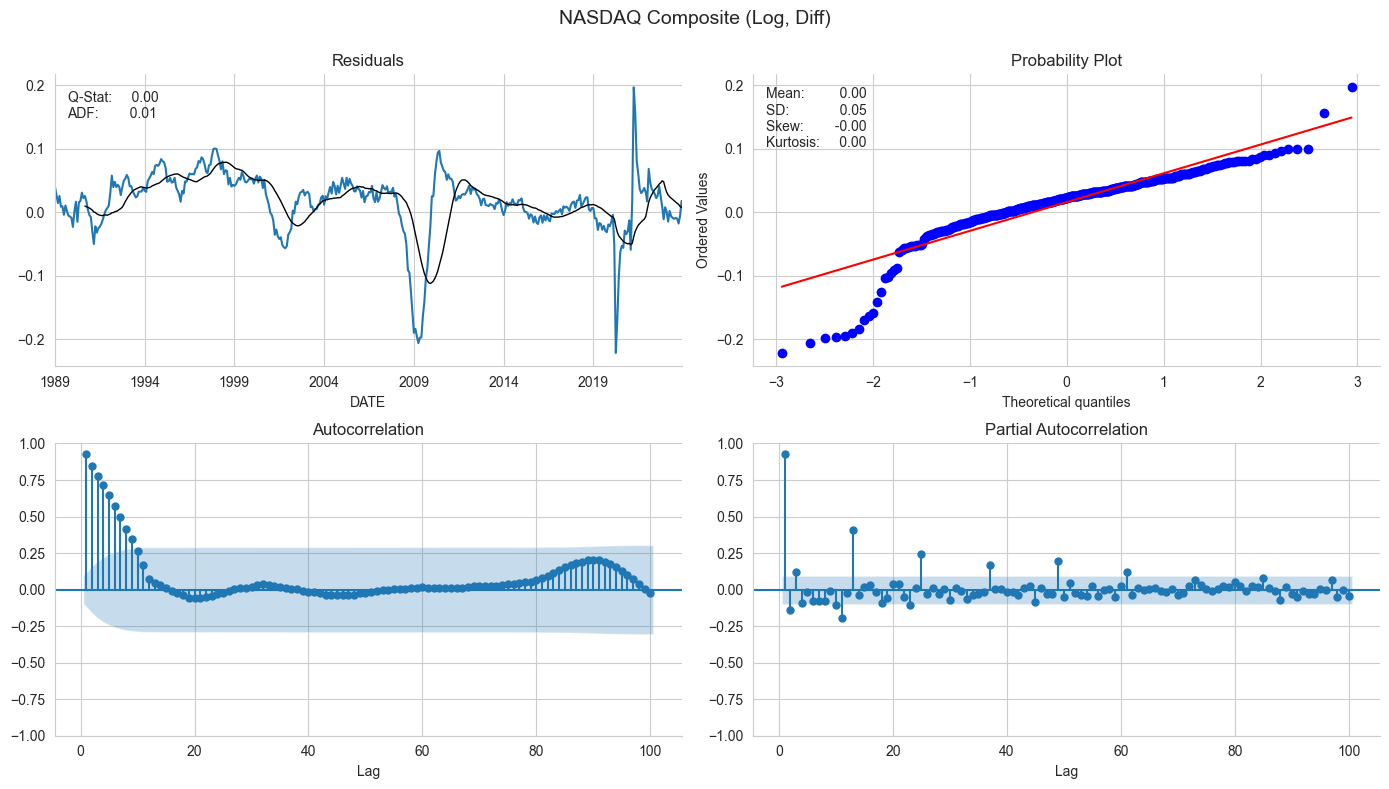

In [17]:
plot_correlogram(industrial_production_log_diff, lags=100, title='NASDAQ Composite (Log, Diff)')